In [133]:
import torch
import torchvision
import torchvision.transforms as transforms

print(f"GPU available: {torch.cuda.is_available()}")

GPU available: True


In [134]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
device

device(type='cuda')

In [135]:
transform = transforms.Compose([transforms.ToTensor(),
                               transforms.Normalize((0.5, ), (0.5, ))])

In [136]:
train_set = torchvision.datasets.MNIST('mnist',
                                       train=True,
                                       download=True,
                                       transform=transform)

test_set = torchvision.datasets.MNIST('mnist',
                                      train=False,
                                      download=True,
                                      transform=transform)

In [137]:
print(f"Train set : {train_set.data.shape}")
print(f"Test set : {test_set.data.shape}")

Train set : torch.Size([60000, 28, 28])
Test set : torch.Size([10000, 28, 28])


In [138]:
import numpy as np
import matplotlib.pyplot as plt

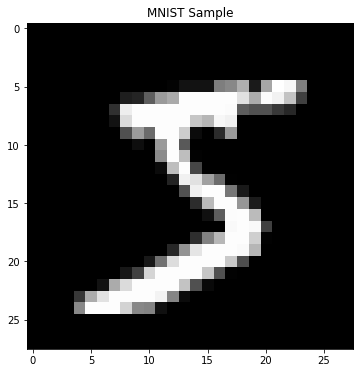

In [139]:
def imshow(title="", image=None, size=6):
    h, w = image.shape[0], image.shape[1]
    aspect_ratio = w / h
    plt.figure(figsize=(size * aspect_ratio, size))
    plt.imshow(image.numpy(), cmap='gray')
    plt.title(title)
    plt.show()


image = train_set.data[0]
imshow("MNIST Sample", image)

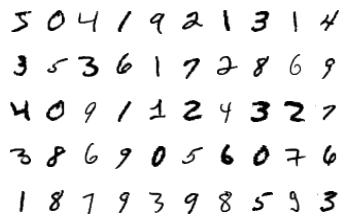

In [140]:
figure = plt.figure()
num_of_images = 50

for i in range(0, num_of_images):
    plt.subplot(5, 10, i + 1)
    plt.axis('off')
    plt.imshow(train_set.data[i], cmap='gray_r')

In [141]:
train_loader = torch.utils.data.DataLoader(train_set,
                                           batch_size=128,
                                           shuffle=True,
                                           num_workers=6)

test_loader = torch.utils.data.DataLoader(test_set,
                                          batch_size=128,
                                          shuffle=False,
                                          num_workers=6)

In [142]:
data_iter = iter(train_loader)

images, labels = data_iter.next()

print(images.shape)
print(labels.shape)

torch.Size([128, 1, 28, 28])
torch.Size([128])


In [143]:
labels[0]

tensor(7)

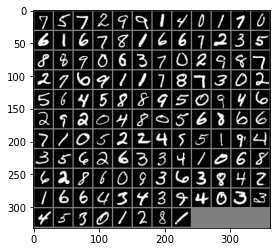

In [144]:
def imshow_v2(img):
    img = img / 2 + 0.5  # unnormalize
    plt.imshow(np.transpose(img.numpy(), (1, 2, 0)))
    plt.show()


imshow_v2(torchvision.utils.make_grid(images, nrow=12))

In [ ]:
a = torch.randn((16, 3,5,5))

In [ ]:
torch.flatten(a, start_dim=1).shape

torch.Size([16, 75])

In [35]:
import torch.nn as nn
import torch.nn.functional as F

In [61]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=0)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=0)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(64 * 12 * 12, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.pool(x)

        x = torch.flatten(x, start_dim=1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)

        return x

In [108]:
net = Net().to(device)
net

Net(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=9216, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)

In [109]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()

optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [110]:
from tqdm.autonotebook import tqdm

epochs = 10

epoch_log = []
loss_log = []
accuracy_log = []

for epoch in range(epochs):
    with tqdm(train_loader, desc=f"Train Epoch {epoch}", unit="batch") as train_epoch:
        batch_id = 0
        running_loss = 0.0

        for inputs, labels in train_epoch:
            net.train()
            batch_id += 1

            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            if batch_id % 50 == 0:

                avg_train_loss_from_last_50_samples = running_loss / 50
                running_loss = 0.0

                correct_count = 0
                total = 0
                net.eval()

                with torch.no_grad():
                    for inputs, labels in test_loader:

                        inputs = inputs.to(device)
                        labels = labels.to(device)

                        outputs = net(inputs)

                        _, predicted = torch.max(outputs, dim=1)
                        total += labels.shape[0]
                        correct_count += (predicted == labels).sum().item()

                    val_accuracy = 100.0 * correct_count / total
                    print(f"loss_avg={avg_train_loss_from_last_50_samples}, val_accuracy={val_accuracy}")
                    train_epoch.set_postfix(loss_avg=avg_train_loss_from_last_50_samples, val_accuracy=val_accuracy)

        epoch_log.append(epoch)
        loss_log.append(avg_train_loss_from_last_50_samples)
        accuracy_log.append(val_accuracy)

Train Epoch 0:   0%|          | 0/469 [00:00<?, ?batch/s]

loss_avg=2.275164918899536, val_accuracy=28.73
loss_avg=2.1643202781677244, val_accuracy=65.32
loss_avg=1.87211980342865, val_accuracy=66.37
loss_avg=1.2755048763751984, val_accuracy=79.07
loss_avg=0.7379804563522339, val_accuracy=85.7
loss_avg=0.5310104537010193, val_accuracy=88.34
loss_avg=0.4350483685731888, val_accuracy=89.39
loss_avg=0.4029759991168976, val_accuracy=90.17
loss_avg=0.3652079141139984, val_accuracy=90.64


Train Epoch 1:   0%|          | 0/469 [00:00<?, ?batch/s]

loss_avg=0.330785308778286, val_accuracy=91.54
loss_avg=0.3104289519786835, val_accuracy=91.49
loss_avg=0.30427720755338666, val_accuracy=92.18
loss_avg=0.289683598279953, val_accuracy=92.32
loss_avg=0.27661416202783584, val_accuracy=92.57
loss_avg=0.271529792547226, val_accuracy=92.77
loss_avg=0.2673311868309975, val_accuracy=93.05
loss_avg=0.24543513894081115, val_accuracy=93.25
loss_avg=0.2642786082625389, val_accuracy=93.19


Train Epoch 2:   0%|          | 0/469 [00:00<?, ?batch/s]

loss_avg=0.24299365371465684, val_accuracy=93.51
loss_avg=0.22588362842798232, val_accuracy=94.01
loss_avg=0.2110210758447647, val_accuracy=94.02
loss_avg=0.2190115988254547, val_accuracy=94.36
loss_avg=0.2151029349863529, val_accuracy=94.36
loss_avg=0.2041915999352932, val_accuracy=94.51
loss_avg=0.18628581807017328, val_accuracy=94.68
loss_avg=0.1954023690521717, val_accuracy=94.84
loss_avg=0.19001950830221176, val_accuracy=95.15


Train Epoch 3:   0%|          | 0/469 [00:00<?, ?batch/s]

loss_avg=0.17917096436023713, val_accuracy=95.26
loss_avg=0.16118152901530267, val_accuracy=95.39
loss_avg=0.16301996931433677, val_accuracy=95.49
loss_avg=0.16665878519415855, val_accuracy=95.71
loss_avg=0.16353494673967361, val_accuracy=95.89
loss_avg=0.1591565027832985, val_accuracy=95.96
loss_avg=0.15115120634436607, val_accuracy=95.93
loss_avg=0.1548342251777649, val_accuracy=96.06
loss_avg=0.14821820557117463, val_accuracy=96.16


Train Epoch 4:   0%|          | 0/469 [00:00<?, ?batch/s]

loss_avg=0.12966903783380984, val_accuracy=96.36
loss_avg=0.14614367060363292, val_accuracy=96.42
loss_avg=0.12661713853478432, val_accuracy=96.45
loss_avg=0.12388610981404781, val_accuracy=96.54
loss_avg=0.13015199989080428, val_accuracy=96.59
loss_avg=0.12582602798938752, val_accuracy=96.55
loss_avg=0.1226601654291153, val_accuracy=96.71
loss_avg=0.12822641097009183, val_accuracy=96.86
loss_avg=0.10938922464847564, val_accuracy=96.86


Train Epoch 5:   0%|          | 0/469 [00:00<?, ?batch/s]

loss_avg=0.11815096005797386, val_accuracy=96.87
loss_avg=0.11334325551986695, val_accuracy=97.04
loss_avg=0.11296146631240844, val_accuracy=97.02
loss_avg=0.1057428902387619, val_accuracy=97.13
loss_avg=0.10706696815788747, val_accuracy=97.24
loss_avg=0.10311518229544163, val_accuracy=97.24
loss_avg=0.09702155262231826, val_accuracy=97.15
loss_avg=0.09638205397874117, val_accuracy=97.27
loss_avg=0.09275093868374824, val_accuracy=97.31


Train Epoch 6:   0%|          | 0/469 [00:00<?, ?batch/s]

loss_avg=0.08915647841989995, val_accuracy=97.39
loss_avg=0.10187864892184734, val_accuracy=97.46
loss_avg=0.09181412704288959, val_accuracy=97.33
loss_avg=0.08686641179025173, val_accuracy=97.34
loss_avg=0.09159969054162502, val_accuracy=97.4
loss_avg=0.0945227836817503, val_accuracy=97.55
loss_avg=0.08998147640377283, val_accuracy=97.49
loss_avg=0.09016866777092218, val_accuracy=97.56
loss_avg=0.08715425595641137, val_accuracy=97.56


Train Epoch 7:   0%|          | 0/469 [00:00<?, ?batch/s]

loss_avg=0.07835084050893784, val_accuracy=97.64
loss_avg=0.09028005056083202, val_accuracy=97.64
loss_avg=0.08664377585053444, val_accuracy=97.64
loss_avg=0.08060188472270965, val_accuracy=97.7
loss_avg=0.07562211576849222, val_accuracy=97.68
loss_avg=0.0874302464351058, val_accuracy=97.71
loss_avg=0.08333665642887354, val_accuracy=97.77
loss_avg=0.07084723606705666, val_accuracy=97.93
loss_avg=0.07187576998025179, val_accuracy=97.83


Train Epoch 8:   0%|          | 0/469 [00:00<?, ?batch/s]

loss_avg=0.07678312178701162, val_accuracy=97.96
loss_avg=0.0766891661658883, val_accuracy=97.9
loss_avg=0.07447562258690596, val_accuracy=97.92
loss_avg=0.07372169610112905, val_accuracy=98.0
loss_avg=0.07206631543114782, val_accuracy=97.91
loss_avg=0.06935095503926277, val_accuracy=97.84
loss_avg=0.079477130882442, val_accuracy=97.9
loss_avg=0.06661914724856616, val_accuracy=98.06
loss_avg=0.06145641800016165, val_accuracy=98.05


Train Epoch 9:   0%|          | 0/469 [00:00<?, ?batch/s]

loss_avg=0.06031627543270588, val_accuracy=98.05
loss_avg=0.06784990057349205, val_accuracy=98.02
loss_avg=0.06283300831913947, val_accuracy=98.09
loss_avg=0.06979218672960996, val_accuracy=98.17
loss_avg=0.06226468697190285, val_accuracy=98.12
loss_avg=0.07118719432502985, val_accuracy=98.07
loss_avg=0.060912214927375315, val_accuracy=98.14
loss_avg=0.06915278777480126, val_accuracy=98.18
loss_avg=0.0700179111585021, val_accuracy=98.16


In [111]:
torch.save(net.state_dict(), 'model.pth')

In [112]:
trained_model = Net().to(device)
trained_model.load_state_dict(torch.load('model.pth'))

<All keys matched successfully>

images shape : torch.Size([128, 1, 28, 28])
labels shape : torch.Size([128])
outputs shape : torch.Size([128, 10])
predictions shape : torch.Size([128])


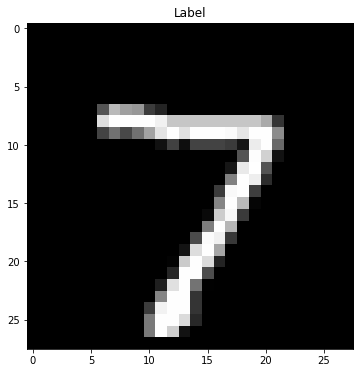

Label : 7
Predicted : 7


In [145]:
test_iter = iter(test_loader)

images, labels = test_iter.next()


print(f"images shape : {images.shape}")
print(f"labels shape : {labels.shape}")

images = images.to(device)
labels = labels.to(device)

outputs = trained_model(images)
print(f"outputs shape : {outputs.shape}")

_, predictions = torch.max(outputs, 1)
print(f"predictions shape : {predictions.shape}")

imshow(f"Label", images[0].cpu().squeeze())
print(f"Label : {labels[0].cpu()}")
print(f"Predicted : {predictions[0]}")

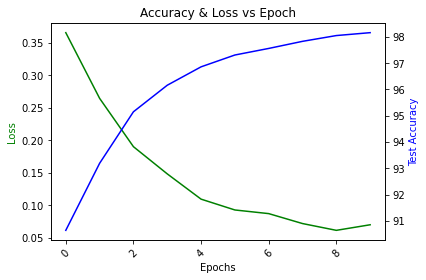

In [146]:
fig, ax1 = plt.subplots()

plt.title('Accuracy & Loss vs Epoch')
plt.xticks(rotation=45)

ax2 = ax1.twinx()

ax1.plot(epoch_log, loss_log, 'g-')
ax2.plot(epoch_log, accuracy_log, 'b-')

ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss', color='g')
ax2.set_ylabel('Test Accuracy', color='b')

plt.show()